In [1]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import scipy.io
from scipy.sparse import csgraph
from sklearn.metrics.pairwise import pairwise_distances
from scipy.linalg import toeplitz
import magic

from sklearn.decomposition import PCA
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score

import os
import sys
from importlib import reload

import filters
import imputation
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot
import spectral

In [3]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}
chromOrder = list(chromDict.values())

In [4]:
filepath = "filtered_data/nagano2017rpkm1Mb.csv"
rna = pd.read_csv(filepath)
print(f"{rna.shape=}")

rna.shape=(182, 5)


In [5]:
filepath = "filtered_data/clique1MBfiltered.csv"

df = pd.read_csv(filepath)
print(f"{df.shape=}")

filteredCells = {}

for runId in df['cell'].unique():
    tmp = df[df['cell'] == runId]
    filteredCells[runId] = tmp.reset_index(drop=True)
    

print(f"\n{filteredCells.keys()=}")

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


df.shape=(636130, 65)

filteredCells.keys()=dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])


In [6]:
resolution = 1000000 # 1mb scale

totalLength = assembly['chromEnd'].max()
bins = binning.getBins(totalLength, resolution)

label1 = 'bin1'
label2 = 'bin2'

binnedData = {}
matrices = {}

for runId, data in filteredCells.items():
    binned = binning.wholeGenomeBinData(data, bins, label1, label2)
    binnedData[runId] = binned
      
    A = pcu.getHic(binned, bins, label1, label2)
    print(f"{runId=} {A.shape=}")
    matrices[runId] = A
    
print(f"{matrices.keys()}")

runId='run01' A.shape=(2724, 2724)
runId='run02' A.shape=(2724, 2724)
runId='run04' A.shape=(2724, 2724)
runId='run05' A.shape=(2724, 2724)
runId='run06' A.shape=(2724, 2724)
runId='run07' A.shape=(2724, 2724)
dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])


In [7]:
newRows = []

for idx, row in assembly.iterrows():
    if "NC" in row['RefSeq accession']:
        
        start = binning.returnBin(row['chromStart'], bins) + 2
        end = binning.returnBin(row['chromEnd'], bins) + 3
        
        newRow = {
            'region' : f"chr{row['Chromosome']}",
            'start' : start,
            'end' : end,
            'length' : end - start,
        }
        
        newRows.append(newRow)
        
filteredChromInfo = pd.DataFrame(newRows)
filteredPoreCIndex = list(range(0, len(matrices['run01'])))

In [9]:
matricesCh2 = {}
rawMatricesChr2 = {}
chromosome = ['chr2']

for runId, mat in matrices.items():
     
    ind = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')
    A = mat[:, ind][ind, :]
    
    A = np.where(A > 0, 1, 0)
    
    rawMatricesChr2[runId] = A
    
    # force diagonal and force adjacent connections
    A = pcu.dropZeroRows(A, threshold=1)
    np.fill_diagonal(A, 1)
    A = pcu.forceAdjacentConnections(A)
    
    print(f"{runId=} {A.shape=}")
    
    matricesCh2[runId] = A

print(matricesCh2.keys())
print('done.')

runId='run01' A.shape=(176, 176)
runId='run02' A.shape=(174, 174)
runId='run04' A.shape=(147, 147)
runId='run05' A.shape=(164, 164)
runId='run06' A.shape=(165, 165)
runId='run07' A.shape=(168, 168)
dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])
done.


(174, 174)


Text(0.5, 1.0, 'Gene Expression (rpkm)')

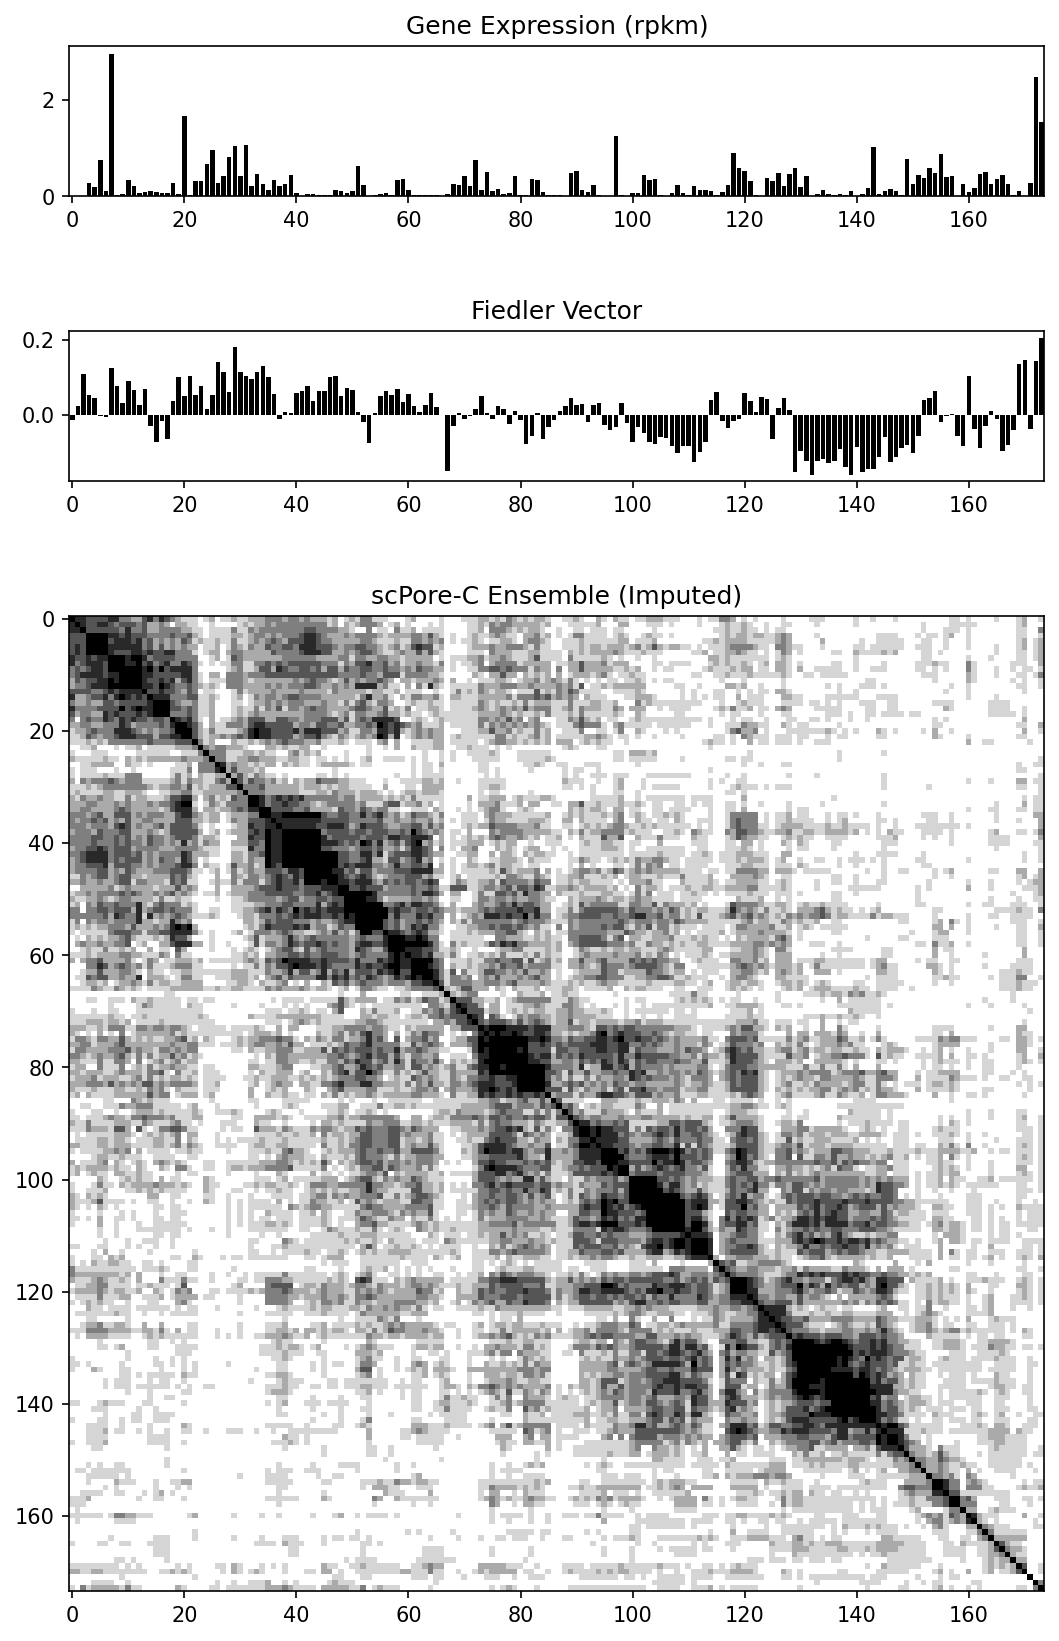

In [11]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 10, 10

# create ensemble
Apool = np.zeros((182, 182))

tau = 0.6
d = 0.5

for runId, A in rawMatricesChr2.items():
    A = np.where(A > 0, 1 , 0)
    np.fill_diagonal(A, 1)
#     A = pcu.forceAdjacentConnections(A)
    A = imputation.imputeEdges(A, tau, method=4, return_scores=False) 
    Apool += A
    
Apool, rmInd = pcu.dropZeroRows(Apool, threshold=50, return_ind=True)
Apool = pcu.pageRankNorm(Apool, d=d)
print(f"{Apool.shape}")

# normalize
Anormed = pcu.normalizeToeplitz(Apool)

# compute fiedler vector
L = csgraph.laplacian(Anormed, normed=True)
w, v = np.linalg.eigh(L)
fIndx = 1 # second position
fiedlerNumber = w[fIndx]
fiedlerVector = v[:, fIndx]

"""
plot
"""

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.05

hicPlotSize = [left, bottom, width, height]
newBottom = bottom + 0.69 + spacing
barPlotSize = [left, newBottom, width, 0.1]
barPlotSize2 = [left, newBottom + 0.14 + spacing, width, 0.1]

fig = plt.figure()
    
ax1 = fig.add_axes(hicPlotSize)
ax1.imshow(Apool, cmap='binary')
ax1.set_title(f'scPore-C Ensemble (Imputed)')


ax2 = fig.add_axes(barPlotSize, sharex=ax1)
ax2.bar(range(len(fiedlerVector)), fiedlerVector, color='k')
ax2.set_title(f'Fiedler Vector')

# remove the dropped bins
rpkm = rna['rpkm'].to_numpy()
rpkm = np.delete(rpkm, rmInd)

ax3 = fig.add_axes(barPlotSize2, sharex=ax1)
ax3.bar(range(len(fiedlerVector)), rpkm, color='k')
ax3.set_title(f'Gene Expression (rpkm)')

Text(0, 0.5, 'RPKM')

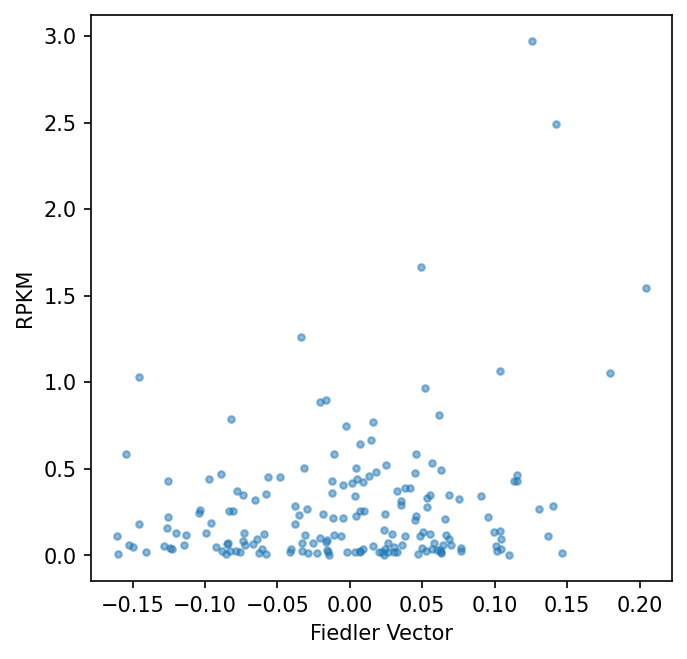

In [18]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 5, 5

plt.scatter(fiedlerVector, rpkm, alpha=0.5, s=10)
plt.xlabel('Fiedler Vector')
plt.ylabel('RPKM')